# Berechnung der Modulparameter für Winaico WST 375MG

In [5]:
from pvlib import ivtools
import pandas as pd
import matplotlib.pyplot as plt

# Winaico WST-375MG
def cec_params_winaico_wst_375mg():
    return {'ivcurve': {'V_mp_ref': 34.46, 'I_mp_ref': 10.95, 'V_oc_ref': 41.08,
                        'I_sc_ref': 11.47},
            'specs': {'alpha_sc': 0.0046, 'beta_voc': -0.115,
                      'gamma_pmp': -0.35, 'cells_in_series': 120}
            }

# alpha_sc : float
#         Temperature coefficient of short circuit current [A/C] 0.04%/C => 0.04% * 11.47 / 100
#     beta_voc : float
#         Temperature coefficient of open circuit voltage [V/C]: -0.28%/C = > -0.28 * 41,08 / 100
#     gamma_pmp : float
#         Temperature coefficient of power at maximum point point [%/C] !!
#     cells_in_series : int
#         Number of cells in series
#     temp_ref : float, default 25
#         Reference temperature condition [C]

# Install NREL-pysam
# pip install nrel-pysam
# or
# conda install -u nrel nrel-pysam nrel-pysam-stubs

input_data = cec_params_winaico_wst_375mg()['ivcurve']
specs = cec_params_winaico_wst_375mg()['specs']

I_L_ref, I_o_ref, R_s, R_sh_ref, a_ref, Adjust = ivtools.sdm.fit_cec_sam(
            celltype='monoSi', v_mp=input_data['V_mp_ref'],
            i_mp=input_data['I_mp_ref'], v_oc=input_data['V_oc_ref'],
            i_sc=input_data['I_sc_ref'], alpha_sc=specs['alpha_sc'],
            beta_voc=specs['beta_voc'],
            gamma_pmp=specs['gamma_pmp'],
            cells_in_series=specs['cells_in_series'])

module_parameters = {
    'I_L_ref': I_L_ref,
    'I_o_ref': I_o_ref,
    'R_s': R_s,
    'R_sh_ref': R_sh_ref,
    'a_ref': a_ref,
    'Adjust': Adjust,
    'Technology': 'Mono-c-Si',    
    'Bifacial': 0,
    'STC': 375.0,
    'PTC': 273.0,
    'A_c': 1.818,
    'Length': 1.759,
    'Width': 1.034,
    'N_s': specs['cells_in_series'],
    'I_sc_ref': input_data['I_sc_ref'],   
    'V_oc_ref': input_data['V_oc_ref'], 
    'I_mp_ref': input_data['I_mp_ref'],  
    'V_mp_ref': input_data['V_mp_ref'], 
    'alpha_sc': specs['alpha_sc'],
    'beta_oc': specs['beta_voc'],
    'T_NOCT': 43.85,
    'gamma_r': specs['gamma_pmp'],
    'BIPV': 'N',
    'Date': '1/3/2019',
    'Version': 'TMS 2023.03.15 r1',
}

# For comparison 
ivtools.sdm.fit_desoto(v_mp=input_data['V_mp_ref'], i_mp=input_data['I_mp_ref'], 
               v_oc=input_data['V_oc_ref'], i_sc=input_data['I_sc_ref'], 
               alpha_sc=specs['alpha_sc'], beta_voc=specs['beta_voc'], 
               cells_in_series=specs['cells_in_series'], 
               EgRef=1.121, dEgdT=- 0.0002677, temp_ref=25, irrad_ref=1000, root_kwargs={})


({'I_L_ref': 11.47,
  'I_o_ref': 0.0015915099000190554,
  'R_s': -0.700731747327681,
  'R_sh_ref': 100.0,
  'a_ref': 4.624664241717539,
  'alpha_sc': 0.0046,
  'EgRef': 1.121,
  'dEgdT': -0.0002677,
  'irrad_ref': 1000,
  'temp_ref': 25},
     fjac: array([[ 0.00000000e+00, -5.35571587e-13, -1.00000000e+00,
         -1.66533454e-16, -4.63795669e-14],
        [-4.36961778e-01, -1.04439111e-01,  5.14758399e-14,
          8.88035616e-01,  9.77221686e-02],
        [-8.85932223e-01,  1.81604391e-01, -1.00202536e-13,
         -4.21756079e-01,  6.53127234e-02],
        [ 7.02548615e-02,  9.03884169e-01, -4.66373181e-13,
          1.82727425e-01, -3.80352930e-01],
        [-1.38754299e-01, -3.72968801e-01,  2.42355917e-13,
         -1.11912285e-02, -9.17341962e-01]])
      fun: array([-0.08168552,  0.40920849,  0.26786987,  6.32052178,  3.29696817])
  message: 'The solution converged.'
     nfev: 20
      qtf: array([-0.26786987,  5.92799141, -2.30370261,  0.26505944, -3.23646943])
        r: 

# Anlage Deisenhofen

10 Module nach Süden
10 Module nach Norden

In [39]:
from pvlib import pvsystem, modelchain, location, inverter
import pprint

loca = location.Location(latitude=48.01820, longitude=11.5941, altitude=580, name='Deisenhofen')

temperature_model_parameters=dict(a=-3.56, b=-0.075, deltaT=3)

array_one = pvsystem.Array(pvsystem.FixedMount(surface_tilt=24, surface_azimuth=210), name='SouthFacingArray', 
                     albedo=None, surface_type=None, module=None, module_type=None, 
                     module_parameters=module_parameters, 
                     temperature_model_parameters=temperature_model_parameters, 
                     modules_per_string=10, strings=1, array_losses_parameters=None)
array_two = pvsystem.Array(pvsystem.FixedMount(surface_tilt=24, surface_azimuth=30), name='NorthFacingArray', 
                     albedo=None, surface_type=None, module=None, module_type=None, 
                     module_parameters=module_parameters, 
                     temperature_model_parameters=temperature_model_parameters, 
                     modules_per_string=10, strings=1, array_losses_parameters=None)

#inverters = pvsystem.retrieve_sam('cecinverter')
## Fronius Primo 7.6-1 208-240
#inverter_parameters = inverters['Fronius_USA__Fronius_Primo_7_6_1_208_240__240V_']

# Generation of inverter parameters for Kostal Plenticore 7.0
# https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.inverter.fit_sandia.html
# Method as seen in test for pvlib
dc_voltage=[290.0,570.0,720.0]

dc_voltage_level=[0.1,0.2,0.3,0.5,0.75,1.0]
p_ac_0=7500
p_nt=7.6 # night time consumption

curves = pd.read_csv(r'InverterData.csv', sep= ';')
dc_power = curves['ac_power'] / curves['efficiency']
inverter_parameters = inverter.fit_sandia(ac_power=curves['ac_power'],
                                 dc_power=dc_power,
                                 dc_voltage=curves['dc_voltage'],
                                 dc_voltage_level=curves['dc_voltage_level'],
                                 p_ac_0=p_ac_0, p_nt=p_nt)

pprint.pprint(inverter_parameters)

system_two_arrays = pvsystem.PVSystem(
    arrays=[array_one, array_two],
    inverter_parameters=inverter_parameters
)

mc = modelchain.ModelChain(
    system_two_arrays, 
    loca, 
    aoi_model='no_loss',
    spectral_model='no_loss')

times = pd.date_range('2023-05-26 01:00', '2023-06-03 23:00', freq='5min', tz='Europe/Berlin')

# Generate clearsky data using the Ineichen model, which is the default
# The get_clearsky method returns a dataframe with values for GHI, DNI, and DHI
# Zero values produced by get_clearsky at night time will cause RuntimeWarning in pvlib/tools.py: 359
weather = loca.get_clearsky(times)

pprint.pprint(weather)

mc.run_model(weather)

{'C0': -1.3496678961212299e-06,
 'C1': -2.5841270745480833e-05,
 'C2': 0.000603617736651947,
 'C3': -0.00015296438663457755,
 'Paco': 7500,
 'Pdco': 7759.014350847117,
 'Pnt': 7.6,
 'Pso': 51.554879088733635,
 'Vdco': 570.0}
                           ghi  dni  dhi
2023-05-26 01:00:00+02:00  0.0  0.0  0.0
2023-05-26 01:05:00+02:00  0.0  0.0  0.0
2023-05-26 01:10:00+02:00  0.0  0.0  0.0
2023-05-26 01:15:00+02:00  0.0  0.0  0.0
2023-05-26 01:20:00+02:00  0.0  0.0  0.0
...                        ...  ...  ...
2023-06-03 22:40:00+02:00  0.0  0.0  0.0
2023-06-03 22:45:00+02:00  0.0  0.0  0.0
2023-06-03 22:50:00+02:00  0.0  0.0  0.0
2023-06-03 22:55:00+02:00  0.0  0.0  0.0
2023-06-03 23:00:00+02:00  0.0  0.0  0.0

[2569 rows x 3 columns]


ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: sandia_inverter
  aoi_model: no_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

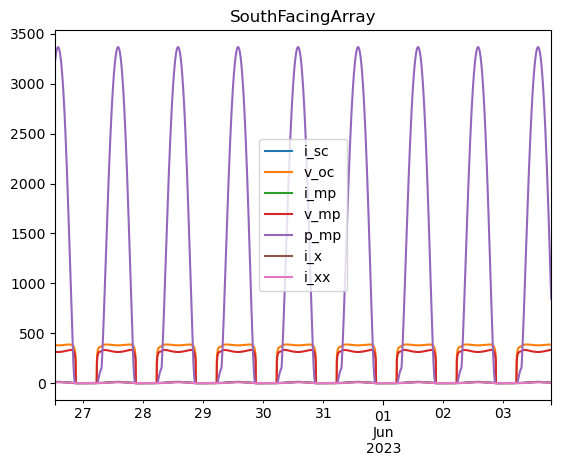

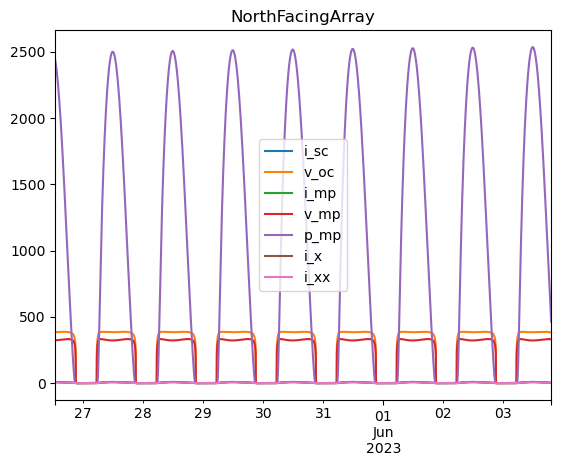

In [15]:
for array, pdc in zip([array_one, array_two], mc.results.dc):
    pdc.plot(title=array.name)
    # mc.results.dc.plot.area(figsize=(12, 4), subplots=True)

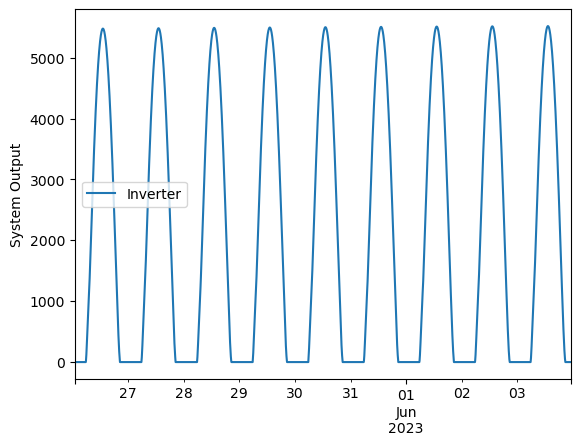

In [40]:
mc.results.ac.plot(label='Inverter')
plt.ylabel('System Output')
plt.legend()
plt.show()

Upload to influxDB

In [41]:
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS

mybucket = "josefpi4"
mytoken = "yP0K9vvgVsJb8OA3NIBz6H0le1eNnT9lz_G0lC1-2XzMg57CyDoZGi6blbnhpxi-ahn0hzrj3vva9y0HoSrocQ=="
myorg = "josefpi4"

client = InfluxDBClient(url="http://192.168.2.40:8086", token=mytoken, org=myorg) # with debugging, debug=True)
write_api = client.write_api(write_options=SYNCHRONOUS)

for array, pdc in zip([array_one, array_two], mc.results.dc):
    print(array.name)
    pd = pdc[['p_mp']]
    
    # Transform DataFrame
    # data = []
    # for index, row in pd.iterrows():
    #     data.append(
    #         {
    #             "measurement": array.name 
    #             "time": index,
    #             "fields": {
    #                 "p_mp": row["p_mp"],
    #             }
    #         }
    #     )
    # write_api.write(bucket=mybucket, record=data)

    # Directly use DataFrame:
    # If the ``data_frame_timestamp_column`` is not specified the index of `Pandas DataFrame <https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html>`_
    write_api.write(bucket=mybucket, record=pd, data_frame_measurement_name=array.name)
    # Without impact  adding  this property to write data_frame_tag_columns=['power'])



SouthFacingArray
NorthFacingArray


# Delete influx measurement
```
influx delete --bucket josefpi4 --org josefpi4 --predicate '_measurement="NorthFacingArray"' --start '2010-01-01T23:00:00Z' --stop  '2024-01-01T23:00:00Z'
```

In [42]:
write_api.write(bucket=mybucket, record=mc.results.ac.to_frame(), data_frame_measurement_name="inverter")

In [46]:
from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write_api import SYNCHRONOUS
import datetime as dt

mybucket = "josefpi4"
mytoken = "yP0K9vvgVsJb8OA3NIBz6H0le1eNnT9lz_G0lC1-2XzMg57CyDoZGi6blbnhpxi-ahn0hzrj3vva9y0HoSrocQ=="
myorg = "josefpi4"

client = InfluxDBClient(url="http://192.168.2.40:8086", token=mytoken, org=myorg)

sdt = dt.datetime(2023, 5, 26, 1, 0, 0, 0, tzinfo=datetime.timezone.utc)
edt = dt.datetime(2023, 6, 1, 23, 0, 0, 0, tzinfo=datetime.timezone.utc)
sdtString = sdt.isoformat()
edtString = edt.isoformat()

query_api = client.query_api()

"""
Query: using Pandas DataFrame
"""

fluxquery = f"""
from(bucket: "josefpi4")
    |> range(start: {sdtString} , stop: {edtString} )
    |> filter(fn: (r) => r._measurement == "SonnenBattery_SolarProduction" and r._field == "value")
    |> aggregateWindow(every: 60s, fn: max)
    |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
    |> keep(columns: [ "_time","value"])
"""

print(fluxquery)

data_frame = query_api.query_data_frame(fluxquery)


fluxquery2 = f"""
from(bucket: "josefpi4")
    |> range(start: {sdtString} , stop: {edtString} )
    |> filter(fn: (r) => r._measurement == "KOSTALPLENTICOREPlus70noBattery_ACPower" and r._field == "value")
    |> fill(value: 0.0)
    |> aggregateWindow(every: 60s, fn: max)
    |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
    |> keep(columns: [ "_time","value"])
"""

fluxquery3 = f"""
from(bucket: "josefpi4")
    |> range(start: {sdtString} , stop: {edtString} )
    |> filter(fn: (r) => r._measurement == "KOSTALPLENTICOREPlus70noBattery_PVStr1Power" and r._field == "value")
    |> fill(value: 0.0)
    |> aggregateWindow(every: 60s, fn: max)
    |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
    |> keep(columns: [ "_time","value"])
"""

fluxquery4 = f"""
from(bucket: "josefpi4")
    |> range(start: {sdtString} , stop: {edtString} )
    |> filter(fn: (r) => r._measurement == "KOSTALPLENTICOREPlus70noBattery_PVStr2Power" and r._field == "value")
    |> fill(value: 0.0)
    |> aggregateWindow(every: 60s, fn: max)
    |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
    |> keep(columns: [ "_time","value"])
"""

data_frame2 = query_api.query_data_frame(fluxquery2).fillna(0)

data_frame3 = query_api.query_data_frame(fluxquery3).fillna(0)

data_frame4 = query_api.query_data_frame(fluxquery4).fillna(0)

#Close client

client.close()

data_frame2



from(bucket: "josefpi4")
    |> range(start: 2023-05-26T01:00:00+00:00 , stop: 2023-06-01T23:00:00+00:00 )
    |> filter(fn: (r) => r._measurement == "SonnenBattery_SolarProduction" and r._field == "value")
    |> aggregateWindow(every: 60s, fn: max)
    |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
    |> keep(columns: [ "_time","value"])



,result,table,_time,value
0,_result,0,2023-05-26 01:01:00+00:00,0.0
1,_result,0,2023-05-26 01:02:00+00:00,0.0
2,_result,0,2023-05-26 01:03:00+00:00,0.0
3,_result,0,2023-05-26 01:04:00+00:00,0.0
4,_result,0,2023-05-26 01:05:00+00:00,0.0
...,...,...,...,...
9955,_result,0,2023-06-01 22:56:00+00:00,0.0
9956,_result,0,2023-06-01 22:57:00+00:00,0.0
9957,_result,0,2023-06-01 22:58:00+00:00,0.0
9958,_result,0,2023-06-01 22:59:00+00:00,0.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


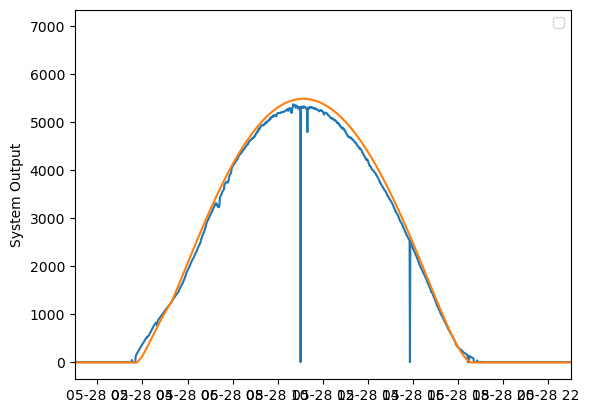

In [47]:
# plot = mc.results.ac.plot(label='Inverter')
import datetime
# plt.plot(data_frame["_time"], data_frame["value"])
plt.plot(data_frame2["_time"], data_frame2["value"])
#plt.plot(data_frame2["_time"], data_frame2["value"])
#plt.plot(data_frame3["_time"], data_frame3["value"])
plt.plot(mc.results.ac)
#mc.results.ac.plot(label='Inverter')
#plt.plot(data_frame4["_time"], data_frame4["value"])

plt.ylabel('System Output')
sdtzoom = dt.datetime(2023, 5, 28, 1, 0, 0, 0, tzinfo=datetime.timezone.utc)
edtzoom = dt.datetime(2023, 5, 28, 23, 0, 0, 0, tzinfo=datetime.timezone.utc)
plt.xlim([sdtzoom, edtzoom])
plt.legend()
plt.show()

In [20]:

query_api.query_data_frame?


In [19]:
pdc.plot?


In [54]:
mc.results?

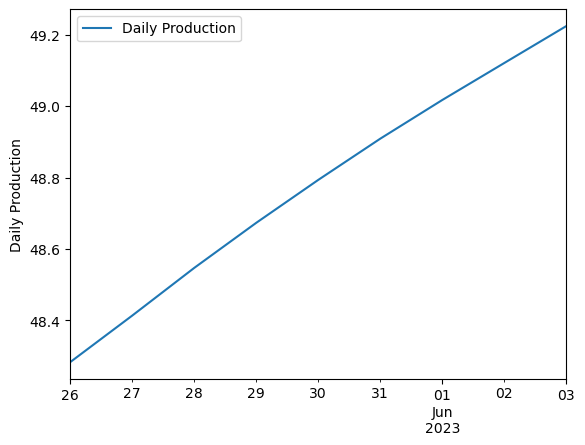

In [50]:
import pandas as pd
results = pd.DataFrame({
    'Daily Production': mc.results.ac
})
results.resample('d').sum().mul(300/1000/3600).plot()
plt.ylabel('Daily Production')
plt.show()